# **Гравитационный поиск. Gravitational Search**
Гравитационный поиск (GS) является очень молодым алгоритмом. Появился он в 2009 году и являлся логическим развитием метода центральной силы. Основу GS составляют законы гравитации и взаимодействия масс. В принципе, данный алгоритм похож на методы роя частиц (Particle Swarm Optimization — PSO), так как базируется на развитии многоагентной системы.

***Используемые законы:***


1.   тяготения: каждая частица притягивает другие и сила притяжения между двумя частицами прямо пропорциональна произведению их масс и обратно пропорциональна расстоянию между ними (следует обратить внимание на то, что в отличие от Всемирного закона тяготения используется не квадрат расстояния; Рашеди объясняет это тем, что во всех тестах это дает лучшие результаты, оставим это на его совести)

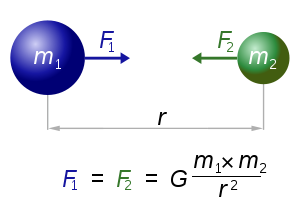

2.   движения: текущая скорость любой частицы равна сумме части скорости в предыдущий момент времени и изменению скорости, которое равно силе, с которой воздействует система на частицу, деленной на инерциальную массу частицы.

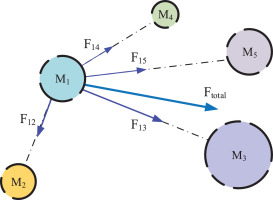


Метод работает по следующему принципу:
1.   генерация системы случайным образом
2.   определение приспособленности каждой частицы
3.   обновление значений гравитационной постоянной, лучшей и худшей частиц, а так же масс
4.   подсчет результирующей силы в различных направлениях
5.   подсчет ускорений и скоростей
6.   обновление позиций частиц
7.   повторений шагов 2 — 6 до выполнения критерия окончания - по истечению заданного количества итераций цикла.


### **Схема алгоритма GS**
**Гравитационную постоянную** image.png или же image.png в алгоритме GS уменьшают с ростом числа итераций по формуле: image.png или 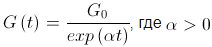  
где G0 (Y0) - ее начальное значение,
Алгоритм использует 3 вида гравитирующих масс: активную mA, пассивную mP и инертную mI.
Гравитационная сила, которая действует на массу mI со стороны массы mj, равна:
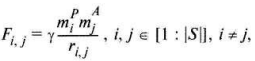
Ускорение, приобретаемое массой mI в результате действия силы Fi,j , определяет формула:
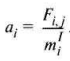
Таким образом, алгоритм GS использует следующее правило вычисления силы, действующей на массу mi со стороны mj по k-му измерению: 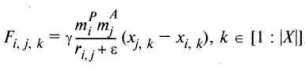
здесь ε - малая константа, r - текущее евклидово расстояние между массами.

Суммарная сила F, действующая на зонд (частицу) si по k-му измерению, полагается случайной величиной, равной: 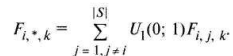



Ускорение указанного зонда по тому же измерению определяется по формуле:
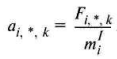

Если положение зонда si по k-му измерению на данной итерации есть xi,k, то на следующей итерации его определяет выражение
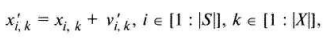
где скорость равна 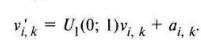

Простейший алгоритм GS предполагает равенство активной, пассивной и инертной масс image.png, точнее полагается, что 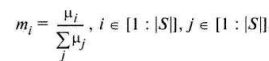
где 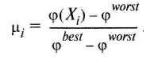

In [ ]:
import random
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation
import copy

In [ ]:
POPULATION = 40
POSITION_MIN = -10
POSITION_MAX = 10
MAX_GENERATIONS = 120
G0 = 1000
EPSILON = 0.0001
#ALPHA = 0.1 # alpha > 0

In [ ]:
# Фитнес функция (Бута)
# f(x,y)=(x+2y-7)^2 + (2x+y-5)^2 (-10,10)
# def fitness_function(particle):
#   x, y = particle
#   return (x+2*y-7)*(x+2*y-7)+(2*x+y-5)*(2*x+y-5)

# f(x,y) = (X^2+y-11)^2+(x+y^2-7)^2 (-5; 5)
def fitness_function(particle):
  x, y = particle
  f = (x ** 2 + y - 11) ** 2 + (x + y ** 2 - 7) ** 2
  return f

# f(x,y) = (x+2*-y+3)^2+(2*x+y-8)^2 [-100; 100]
# def fitness_function(particle):
#   x, y = particle
#   f1=x+2*-y+3
#   f2=2*x+y-8
#   r = f1**2+f2**2
#   return r

In [ ]:
# Приспособленность частицы
class Fitness():
  def __init__(self):
    self.value = -1

# Результирующая сила, действующая на частицу
class Force():
  def _init_(self):
    self.x = 0
    self.y = 0

# Масса частицы
class Mass():
  def __init__(self):
    self.value = 1

# Скорость частицы
class Velocity():
  def __init__(self):
    self.x = 0
    self.y = 0

# Частица
class Particle(list):
  def __init__(self, *args):
    super().__init__(*args)
    self.fitness = Fitness()
    self.force = Force()
    self.mass = Mass()
    self.velocity = Velocity()

In [ ]:
def particleCreator():
    x = random.uniform(POSITION_MIN, POSITION_MAX)
    y = random.uniform(POSITION_MIN, POSITION_MAX)
    return Particle([x, y])

def populationCreator():
    return list([particleCreator() for i in range(POPULATION)])

def clone(particle):
    particle2 = Particle(particle[:])
    particle2.fitness.value = particle.fitness.value
    return particle2

In [ ]:
# Гравитационная постоянная G
def getG(iteration):
  #return G0/np.exp(ALPHA*iteration)
  d = random.uniform(0, 1)
  return G0*(1/iteration)**d

In [ ]:
# Евклидово расстояние между двумя точками
def getEuclideanDistance(particle1, particle2):
  return np.sqrt((particle1[0]-particle2[0])**2+(particle1[1]-particle2[1])**2)

In [ ]:
# Рузультирующая сила, действующая на одну частицу со стороны всех других частиц
def getResultF(particle, particles, G):
  # Список сил, действующих на частицу со стороны каждой другой частицы
  forces_for_particle = []
  # Вычисление сил по x и y, действующих на частицу со стороны каждой другой частицы
  for i in range(len(particles)):
    current_force = getF(particle, particles[i], G)
    forces_for_particle.append(current_force)
  # Вычисление результирующей силы, действующей на частицу
  x_result_particle_force = 0
  y_result_particle_force = 0
  for j in range(len(forces_for_particle)):
    x_result_particle_force += random.uniform(0, 1) * forces_for_particle[j][0]
    y_result_particle_force += random.uniform(0, 1) * forces_for_particle[j][1]
  return [x_result_particle_force, y_result_particle_force]

In [ ]:
# Сила, действующая на одну частицу со стороны одной другой частицы
def getF(particle1, particle2, G):
  x_force = (G * particle1.mass.value * particle2.mass.value * (particle2[0] - particle1[0])) / (getEuclideanDistance(particle1, particle2) + EPSILON)
  y_force = (G * particle1.mass.value * particle2.mass.value * (particle2[1] - particle1[1])) / (getEuclideanDistance(particle1, particle2) + EPSILON)
  return [x_force, y_force]

In [ ]:
# Расчет массы частицы
def getM(particle, particles):
  particles_m_sum = 0
  for i in range(len(particles)):
    particles_m_sum += getm(particles[i], particles)
  return getm(particle, particles)/particles_m_sum

def getm(particle, particles):
  f1 = particle.fitness.value - max(particles, key=lambda p: p.fitness.value).fitness.value
  f2 = min(particles, key=lambda p: p.fitness.value).fitness.value - max(particles, key=lambda p: p.fitness.value).fitness.value
  return f1/f2

In [ ]:
# Расчет новой скорости частицы
def getNewVelocity(particle):
  x_velocity = random.uniform(0, 1) * particle.velocity.x + (particle.force.x * particle.mass.value)
  y_velocity = random.uniform(0, 1) * particle.velocity.y + (particle.force.y * particle.mass.value)
  return [x_velocity, y_velocity]

In [ ]:
# Вычисление новой позиции частицы
def getNewPosition(particle):
  x_position = particle[0]+particle.velocity.x
  y_position = particle[1]+particle.velocity.y
  return [x_position, y_position]

In [ ]:
bestFunctionValues=[]
meanFunctionValues=[]
meanFunctionValuesWithoutScouts=[]

In [ ]:
# Алгоритм гравитационного поиска
def gravitationalSearch():
  # Начальная популяция частиц
  particles = populationCreator()
  # Размер списка лучших частиц
  bestParticlesSize = POPULATION
  # Список частиц за одно поколение (чтобы потом выводить на график как менялось по поколениям)  
  particles_for_generation = []
  # Счетчик поколений
  generationCounter = 0
  while generationCounter < MAX_GENERATIONS:
    # Увеличение счетчика поколения
    generationCounter+=1
    # Сохраняем популяцию частиц
    particles_for_generation.append(copy.deepcopy(particles))
    # Сохраняем и печатаем статистику
    collect_and_print_statistics(particles, generationCounter)
    # Обновляем приспособленность каждой частицы в популяции
    for i in range(len(particles)):
      particles[i].fitness.value = fitness_function(particles[i])
    # Обновляем массу каждой частицы в популяции
    for i in range(len(particles)):
      particles[i].mass.value = getM(particles[i], particles)
    # Рассчитываем гравитационную постоянную
    G = getG(generationCounter)
    # Сортировка частиц по самой лучшей приспособленности (ищем минимум функции, следовательно сортировка по возрастанию)
    clonedParticles = copy.deepcopy(particles)
    clonedParticles.sort(key=lambda p: p.fitness.value)
    # Уменьшаем размер списка лучших частиц если надо
    if generationCounter % (MAX_GENERATIONS//POPULATION) == 0:
      bestParticlesSize-=1
    # Находим лучшие частицы
    bestParticles = []
    for i in range(bestParticlesSize):
      bestParticles.append(clone(clonedParticles[i]))
    # Рассчитываем результирующую силу, действующую на каждую частицу в популяции, исходящую от лучших частиц
    for i in range(len(particles)):
      resultForce = getResultF(particles[i], bestParticles, G)
      particles[i].force.x = resultForce[0]
      particles[i].force.y = resultForce[1]
    # Рассчитываем новую скорость каждой частицы и обновляем позицию частицы
    for i in range(len(particles)):
      # Обновляем скорость частицы
      newVelocity = getNewVelocity(particles[i])
      particles[i].velocity.x = newVelocity[0]
      particles[i].velocity.y = newVelocity[1]
      # Обновляем позицию частицы
      newPosition = getNewPosition(particles[i])
      particles[i][0] = newPosition[0]
      particles[i][1] = newPosition[1]

  return particles_for_generation

In [ ]:
# Сохраняет и печатает статистику
def collect_and_print_statistics(particles, current_generation):
    best_particle = min(particles, key=lambda p: p.fitness.value)
    if current_generation!=1:
      bestFunctionValues.append(best_particle.fitness.value)
    print("Generation: ", current_generation)
    print("Best particle: ", best_particle)
    print("Best particle function value: ", best_particle.fitness.value)

In [ ]:
particles = gravitationalSearch()

Generation:  1
Best particle:  [-5.227283571898331, -5.4257887005822125]
Best particle function value:  -1
Generation:  2
Best particle:  [-5.262204300671668, 1.664616574081432]
Best particle function value:  8.087680259464612
Generation:  3
Best particle:  [2.8641991233214723, -0.7002148185085803]
Best particle function value:  22.10884263699438
Generation:  4
Best particle:  [1.7489308246740451, -0.2345891956030619]
Best particle function value:  0.3681272115859662
Generation:  5
Best particle:  [0.1428578750147378, 0.04395447339156777]
Best particle function value:  20.792726134525655
Generation:  6
Best particle:  [-0.1973322949591223, -1.4293574076736844]
Best particle function value:  15.363817621086469
Generation:  7
Best particle:  [1.5454762905400448, -1.313793824493232]
Best particle function value:  1.0752688615616017
Generation:  8
Best particle:  [-3.1889486774184777, 2.049343461814761]
Best particle function value:  8.325280236772512
Generation:  9
Best particle:  [1.0868

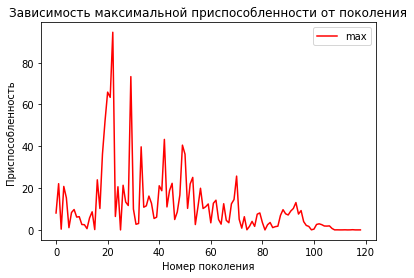

In [ ]:
plt.plot(bestFunctionValues, color='red', label='max')
plt.xlabel('Номер поколения')
plt.ylabel('Приспособленность ')
plt.title('Зависимость максимальной приспособленности от поколения')
plt.legend()
plt.show()

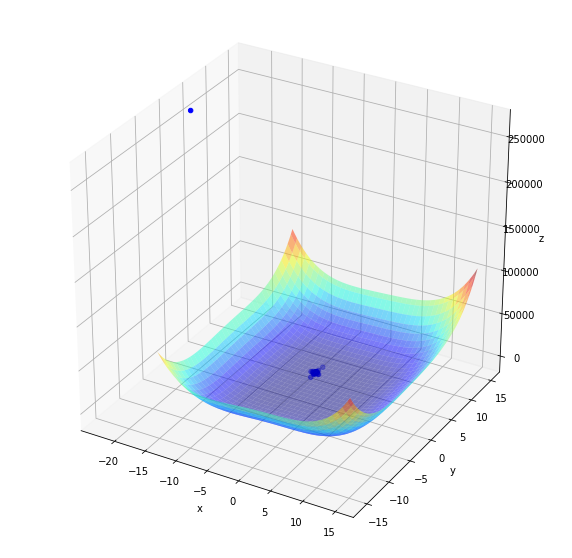

In [ ]:
# Подготовка графика
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
x = np.linspace(-15, 15, 80)
y = np.linspace(-15, 15, 80)
X, Y = np.meshgrid(x, y)
Z= fitness_function([X,Y])
ax.plot_surface(X, Y, Z, cmap='jet', alpha=0.5)
# Другой вид отображения графика
#ax.plot_wireframe(X, Y, Z, color='r', linewidth=0.2)

# Хранит изображение
frames = []
# Добавление изображения для каждого поколения
for t in range(len(particles)):
  frame = ax.scatter3D([particles[t][n][0] for n in range(len(particles[t]))], [particles[t][n][1] for n in range(len(particles[t]))],
                         [fitness_function([particles[t][n][0],particles[t][n][1]]) for n in range(len(particles[t]))], c='b') 
  frames.append([frame])
# Сгенерировать изображение и сохранить
animated_image = animation.ArtistAnimation(fig, # фигура, где отображается анимация
    frames,              # кадры
    interval=120,        # задержка между кадрами в мс
    blit=True,          # использовать ли двойную буферизацию
    repeat=True)       # зацикливать ли анимацию
# Потом нужно отдельно вызвать эту гиф, чтобы показать анимацию
animated_image.save('/content/gravity.gif', writer='pillow') 

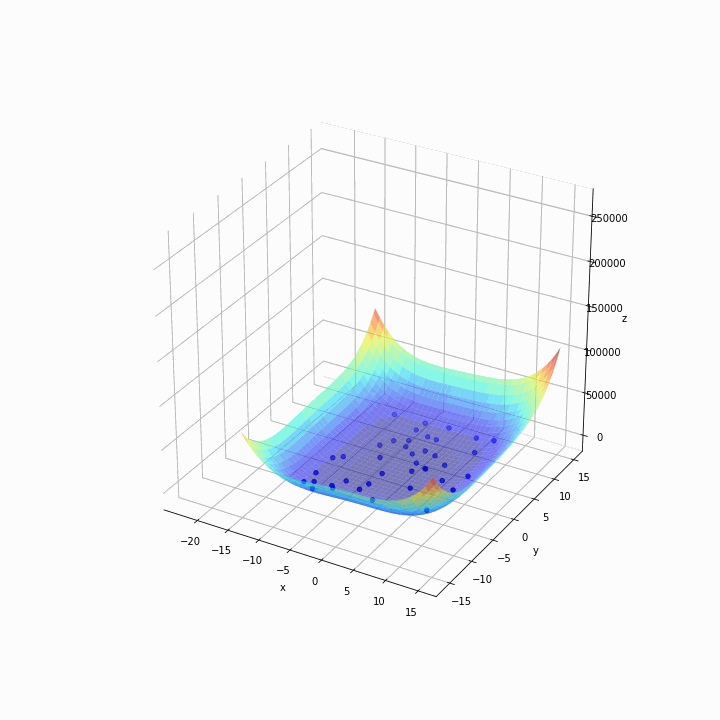

In [ ]:
from IPython.display import Image

fname = '/content/gravity.gif'
Image(open(fname, 'rb').read())